# Multilayer Perceptron (MLP) v2

El Multilayer Perceptron es el tipo de red neuronal profunda más simple que hay, simplemente es una composición de capas *fully-connected* (lineales) + activaciones no lineales. Es común, según aplicaciones, que la salida de la última lineal sea directamente la salida de la red.

**Disclaimer:** esta implementación podría fácilmente adaptarse a esquemas de `batch_size` > 1, pero en pos de maximizar legibilidad se limitó al esquema de SGD estricto.

## Preliminaries

In [ ]:
# lo único que usamos realmente
import numpy as np

# ploteo/info
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# cargado de datasets
from sklearn.datasets import load_iris, fetch_openml, load_wine
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Clases base

In [ ]:
class Operation:
    def __init__(self):
        self.params = dict()

    # syntactic sugar for param access
    def __getattr__(self, name):
        # If the requested attribute is not found, look it up in the params dictionary
        params = object.__getattribute__(self, 'params')
        if name in params:
            return params[name]
        else:
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

    def zero_grad(self):
        self.grad = {k:np.zeros_like(v) for k,v in self.params.items()}

    def forward(self, *args, **kwargs):
        raise NotImplementedError("Override this!")

    def backwards(self, *args, **kwargs):
        raise NotImplementedError("Override this!")

In [ ]:
class Linear(Operation):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.params['W'] = np.random.normal(loc=0, scale=0.1/np.sqrt(out_dim), size=(out_dim, in_dim))
        self.params['b'] = np.random.random_sample(size=(out_dim,1))

    def forward(self, x):
        self.x = x
        self.z = self.W @ self.x + self.b
        return self.z

    def backwards(self, dz):
        self.grad['W'] = dz @ self.x.T
        self.grad['b'] = dz
        return self.W.T @ dz # dx

In [ ]:
class ReLU(Operation):

    def __init__(self):
        super().__init__()

    def forward(self,z):
        self.z = z
        self.y = np.maximum(z,0)
        return self.y

    def backwards(self,dy):
        return dy * (self.y > 0).astype(float)

In [ ]:
class MLP:
    def __init__(self, ops_list, learning_rate, debug=False):
        self.ops = {f"{idx}-{op.__class__.__name__}":op for idx,op in enumerate(ops_list)}
        self.learning_rate = learning_rate
        self.debug = debug

    def forward(self, x):
        for name, op in self.ops.items():
            if self.debug:
                print(f"Input at {name} has shape {x.shape}")
            x = op.forward(x)
        return x

    def zero_grad(self):
        for name, op in self.ops.items():
            if self.debug:
                print(f"Zeroing grad at {name}")
            op.zero_grad()

    def backwards(self, dy):
        for name, op in reversed(self.ops.items()):
            if self.debug:
                print(f"Grad of output from {name} has shape {dy.shape}")

            # backprop
            dy = op.backwards(dy)

            # gradient descent step
            for param_name in op.params:
                op.params[param_name] -= self.learning_rate * op.grad[param_name]

    # syntactic sugar for calling forward
    def __call__(self, x):
        return self.forward(x)

In [ ]:
example_nn = MLP(
    ops_list=[
        Linear(5, 4),
        ReLU(),
        Linear(4,2)
    ],
    learning_rate=0.1,
    debug=True
)

In [ ]:
# show forward
example_nn(np.array([0.1,0.2,0.1,1,-2]).reshape(-1,1))

Input at 0-Linear has shape (5, 1)
Input at 1-ReLU has shape (4, 1)
Input at 2-Linear has shape (4, 1)


array([[-0.00896581],
       [ 0.45446917]])

In [ ]:
# show zerograd
example_nn.zero_grad()

Zeroing grad at 0-Linear
Zeroing grad at 1-ReLU
Zeroing grad at 2-Linear


In [ ]:
# show one param before backwards
example_nn.ops['0-Linear'].W

array([[-0.08550317, -0.06883902, -0.02290559, -0.05557791, -0.05132738],
       [ 0.05495485, -0.04271251, -0.01604932,  0.07253669, -0.02381738],
       [ 0.04049211, -0.12958112,  0.03867941,  0.09885662, -0.05087403],
       [ 0.01699108, -0.0068129 , -0.00360518,  0.05843124, -0.05924249]])

In [ ]:
# show backwards
example_nn.backwards(np.array([0.1,0.2]).reshape(-1,1))

Grad of output from 2-Linear has shape (2, 1)
Grad of output from 1-ReLU has shape (4, 1)
Grad of output from 0-Linear has shape (4, 1)


In [ ]:
# show same param after backwards
example_nn.ops['0-Linear'].W

array([[-0.08524315, -0.06831899, -0.02264557, -0.05297779, -0.05652763],
       [ 0.05503709, -0.04254802, -0.01596707,  0.07335917, -0.02546232],
       [ 0.04075129, -0.12906276,  0.03893859,  0.1014484 , -0.05605758],
       [ 0.01683481, -0.00712545, -0.00376145,  0.0568685 , -0.05611701]])

### Cross Entropy Loss

#### Forward

**Paso 1:**

La pérdida de _cross entropy_ se define para $K$ clases como
$$
\mathcal{L}(p, \hat{p}) = - \sum_{i=1}^K p_i \cdot \log(\hat{p_i})
$$

donde $p$ es la verdadera distribución de probabilidades y $\hat{p}$ la predicción.

**Paso 2:**

En los casos en los que el elemento pertenece a una sola clase, $p$ es un vector de todos $0$ excepto la clase $c$ correcta, donde vale $1$. Esto elimina todos los términos de la sumatoria excepto uno, reduciendo la expresión a:

$$
\mathcal{L}(p, \hat{p}) = - \log(\hat{p_c})
$$

**Paso 3:**

Para calcular las probabilidades $\hat{p}$ a partir de una salida de una capa lineal $z$, lo que se hace es aplicar una función no lineal softmax:

$$
\hat{p}=\text{softmax}(z)= \frac{\exp(z)}{\sum_{i=1}^K{\exp(z_i)}}
$$

es decir, aplicar $\text{exp}$ elemento a elemento y luego dividir por la suma.

Sustituyendo esa expresión en la del paso 2, obtenemos:

$$
\mathcal{L}(p, \hat{p}) = - \log(\frac{\exp(z_c)}{\sum_{i=1}^K{\exp(z_i)}}) = -z_c + \log{\sum_{i=1}^K{\exp(z_i)}}
$$

**Paso 4:**

Por una cuestión de estabilidad numérica, para calcular $\log{\sum_{i=1}^K{\exp(z_i)}}$ se aplica el truco `log-sum-exp`([[1]](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/),[[2]](https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations)) donde se observa que

$$
LSE(z) = \log{\sum_{i=1}^K{e^{z_i}}} = \log{(e^s \cdot \sum_{i=1}^K{e^{z_i-s}})} = s + \log{\sum_{i=1}^K{e^{z_i-s}}}
$$

de donde tomando $s=\max_i\{z\}$ se asegura que uno de los términos vale 1 y todos los demás valen menos.

Aplicando esto, la expresión final resulta entonces:

$$
\mathcal{L}(p, \hat{p}) = - \log(\frac{\exp(z_c)}{\sum_{i=1}^K{\exp(z_i)}}) = -z_c + LSE(z)
$$

#### Backwards

Lamentablemente para el backwards no hay forma eficiente de calcularlo, aunque la expresión, a partir de lo último obtenido es relativamente simple:

* El gradiente del primer término es un vector de casi todos $0$ excepto la clase correcta $c$, donde vale $-1$.
* Para el gradiente del segundo término, alcanza con observar que $\frac{\partial}{\partial z_i} \log{\sum_{i=1}^K{e^{z_i}}} = \frac{1}{\sum_{i=1}^K{e^{z_i}}} e^{z_i} = \frac{e^{z_i}}{\sum_{i=1}^K{e^{z_i}}}$, de donde se obtiene que el gradiente del segundo término es simplemente la softmax de los logits.


In [ ]:
def logsumexp(z):
    s = z.max(axis=0)
    return s+np.log(np.sum(np.exp(z-s), axis=0))

# show usage
aux = np.array([1000,1000,900])
logsumexp(aux)

np.float64(1000.6931471805599)

In [ ]:
# when not using LSE trick
np.log(np.sum(np.exp(aux), axis=0))

/tmp/ipython-input-399849844.py:2: RuntimeWarning: overflow encountered in exp
  np.log(np.sum(np.exp(aux), axis=0))


np.float64(inf)

In [ ]:
class CrossEntropyLoss():

    def forward(self, y_pred, y_true):
        """
        y_pred: float[K,1] logits para cada clase 0,...,K-1
        y_true: int[1,1] clase correcta, con cada elemento en el rango entero [0,K-1]
        """
        self.y_pred = y_pred
        self.y_true = y_true

        return -y_pred[y_true] + logsumexp(y_pred)

    def backwards(self):
        # 2nd term
        s = self.y_pred.max(axis=0)
        unnorm_probs = np.exp(self.y_pred - s)
        softmax = unnorm_probs / unnorm_probs.sum(axis=0)

        # 1st term
        softmax[self.y_true] -= 1

        return softmax

    # syntactic sugar
    def __call__(self, y_pred, y_true):
        return self.forward(y_pred, y_true)

In [ ]:
example_loss = CrossEntropyLoss()
print(example_loss(np.array([1,-2,3]).reshape(-1,1),1))
print(example_loss.backwards())

[5.13284523]
[[ 0.11849965]
 [-0.99410025]
 [ 0.8756006 ]]


## Utils

In [ ]:
# hiperparams
LR = 0.001
EPOCHS = 10
TEST_SZ = 0.3
RNG_SEED = 6543

In [ ]:
def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins_dataset():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

def get_wine_dataset():
    # get data
    data = load_wine()
    X_full = data.data
    y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
    return X_full, y_full

def get_letters_dataset():
    # get data
    letter = fetch_openml('letter', version=1, as_frame=False)
    return letter.data, letter.target.reshape(-1,1)

def label_encode(y_full):
    return LabelEncoder().fit_transform(y_full.flatten()).reshape(y_full.shape)

def split_transpose(X, y, test_size, random_state):
    # X_train, X_test, y_train, y_test but all transposed
    return [elem.T for elem in train_test_split(X, y, test_size=test_size, random_state=random_state)]

In [ ]:
def train_mlp(X_train, y_train, X_test, y_test, model, epochs):

    n_samples_train = y_train.shape[1]
    n_samples_test = y_test.shape[1]
    intra_epoch_costs_historic = np.empty(epochs*n_samples_train, dtype=float)
    train_costs_historic = np.empty(epochs, dtype=float)
    test_costs_historic = np.empty(epochs, dtype=float)

    loss = CrossEntropyLoss()

    loss_whole_train = CrossEntropyLoss()
    loss_whole_test = CrossEntropyLoss()

    for i in tqdm(range(epochs),total=epochs):

        # shuffle train
        indices = np.arange(n_samples_train)
        np.random.shuffle(indices)

        # iterate through shuffled train
        for idx_num, sample_idx in enumerate(indices):

            # zero grad
            model.zero_grad()

            # sample obs
            x = X_train[:,sample_idx].reshape(-1,1)
            y_true = y_train[:,sample_idx]

            # forward pass
            y_pred = model(x)

            # calc loss
            intra_epoch_costs_historic[i*n_samples_train+idx_num] = loss(y_pred, y_true.reshape(1,1)).item()

            # backwards
            model.backwards(loss.backwards())

        # after each epoch, get values of loss at train and test
        train_costs_historic[i] = loss_whole_train(model(X_train),y_train).mean()
        test_costs_historic[i] = loss_whole_test(model(X_test),y_test).mean()

    return intra_epoch_costs_historic, train_costs_historic, test_costs_historic

## Prueba sobre dataset Wine

In [ ]:
X_full, y_full = get_wine_dataset()

X_full.shape, y_full.shape

((178, 13), (178, 1))

In [ ]:
y_full_encoded = label_encode(y_full)

y_full_encoded[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
n_classes = y_full_encoded.max().item() + 1
n_classes

3

In [ ]:
X_train, X_test, y_train, y_test = split_transpose(
    X_full, y_full_encoded,
    test_size=TEST_SZ,
    random_state=RNG_SEED
)

X_train.shape, y_test.shape

((13, 124), (1, 54))

In [ ]:
n_features = X_train.shape[0]
n_features

13

In [ ]:
nn1 = MLP(
    ops_list=[
        Linear(n_features,4),
        ReLU(),
        Linear(4,n_classes)
    ],
    learning_rate=1e-2,
    debug=False
)

In [ ]:
# show usage for 1 sample
nn1(X_train[:,5].reshape(-1,1))

array([[ 0.20189571],
       [-0.04982853],
       [ 0.21486932]])

In [ ]:
intra_epoch_costs_historic, train_costs_historic, test_costs_historic = train_mlp(
    X_train, y_train,
    X_test, y_test,
    model=nn1,
    epochs=EPOCHS
)

  0%|          | 0/10 [00:00<?, ?it/s]

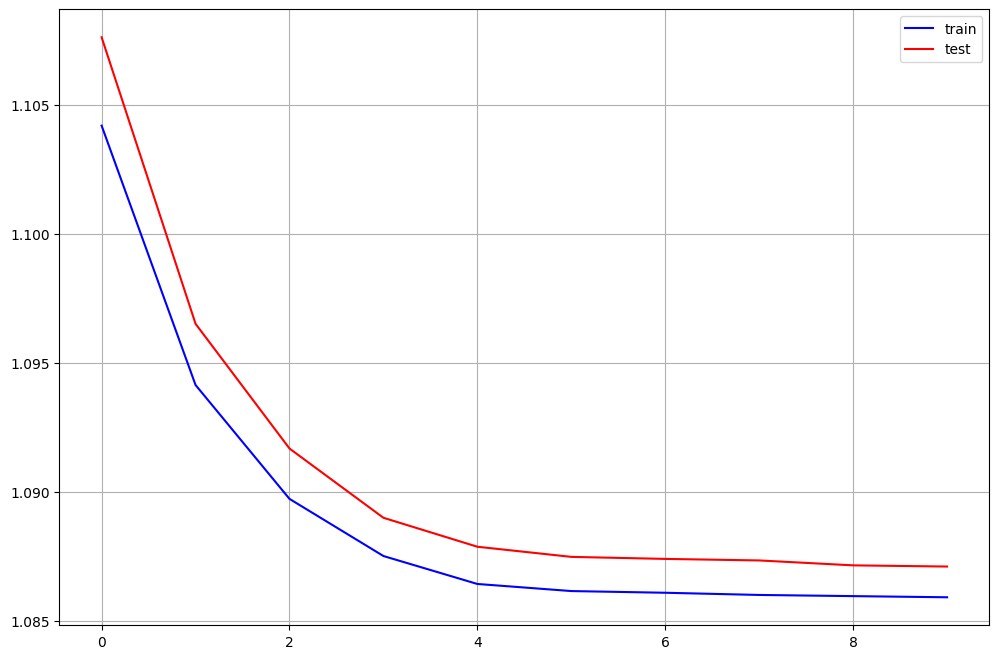

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train_costs_historic, color='blue', label='train')
plt.plot(test_costs_historic, color='red', label='test')
plt.grid(True)
plt.legend()
plt.show()

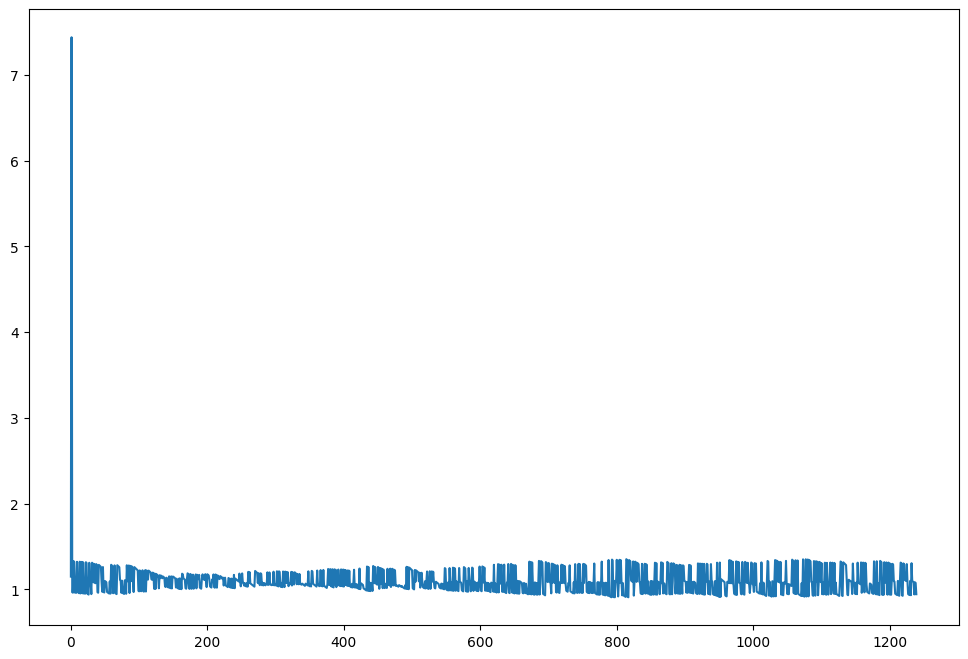

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(intra_epoch_costs_historic)
plt.show()